Ref: https://youtu.be/z3ZnOW-S550?si=UdhGcpfUb2GSZ4zF

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
import io
import boto3
import pandas as pd

s3_uri = "s3://spoofing-ml-exp/Example Data/PJME_hourly.csv"
bucket_name = s3_uri.replace("s3://", "").split("/")[0]
key = "/".join(s3_uri.replace("s3://", "").split("/")[1:])

s3 = boto3.client("s3")
obj = s3.get_object(Bucket=bucket_name, Key=key)
df = pd.read_csv(io.BytesIO(obj["Body"].read()))
print(df.shape, df.head())


(145366, 2)               Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0


In [3]:
# Set the 'Datetime' column as the index of the DataFrame
# This moves the 'Datetime' column from being a regular column to being the row labels/index
df = df.set_index('Datetime')

# Convert the index to pandas datetime format
# This ensures the index is properly recognized as datetime objects rather than strings
# Enables time-series functionality like resampling, filtering by date ranges, etc.
df.index = pd.to_datetime(df.index)

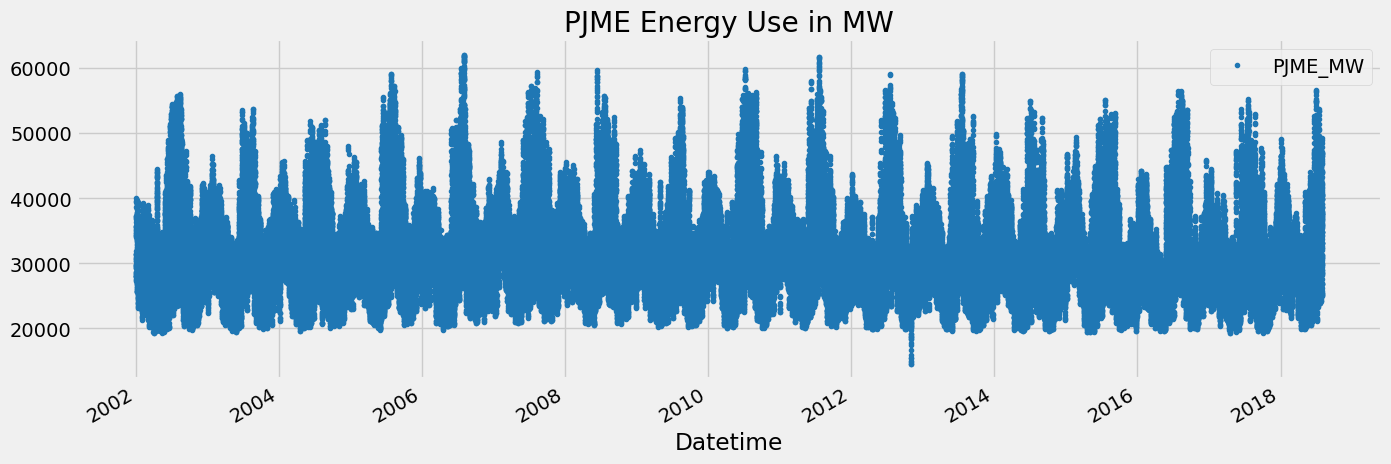

In [4]:
# Create a scatter plot of the time series data
df.plot(
    style='.',           # Use dots/points instead of lines for each data point
    figsize=(15, 5),     # Set figure size to 15 inches wide by 5 inches tall
    color=color_pal[0],  # Use the first color from a predefined color palette
    title='PJME Energy Use in MW'  # Set the plot title
)

# Display the plot in the output
plt.show()

### Outlier Analysis and removal

<Axes: ylabel='Frequency'>

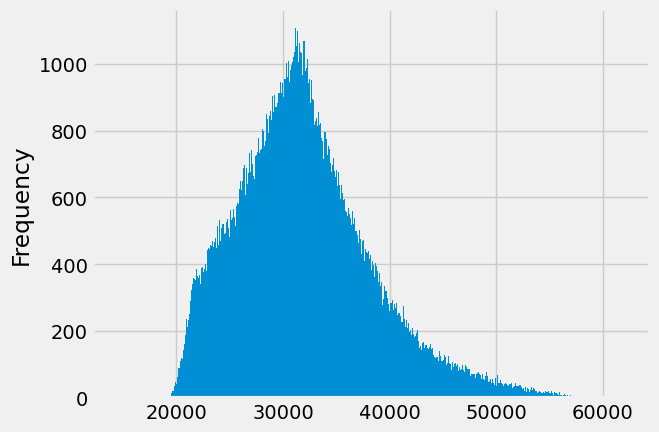

In [5]:
# Create a histogram to show the distribution of energy usage values
df['PJME_MW'].plot(
    kind='hist',    # Specify histogram plot type
    bins=500        # Use 500 bins for fine-grained distribution detail
                    # More bins = smoother distribution curve but may show more noise
                    # Fewer bins = smoother but less detailed distribution
)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

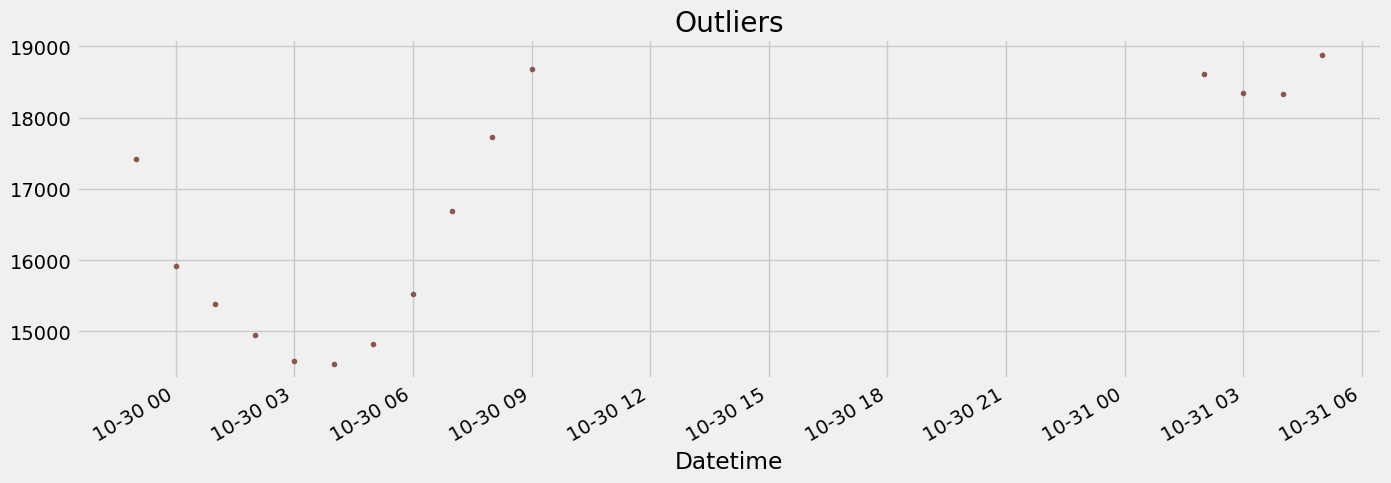

In [6]:
# Filter and plot outliers (unusually low energy usage values)
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(
        style='.',           # Use dots/points for each data point
        figsize=(15, 5),     # Set figure size to 15 inches wide by 5 inches tall  
        color=color_pal[5],  # Use the 6th color from the color palette (different from main plot)
        title='Outliers'     # Title indicating these are outlier values
    )

In [7]:
# Remove outliers from the dataset and create a clean copy
df = df.query('PJME_MW > 19_000').copy()

### Train / Test Split

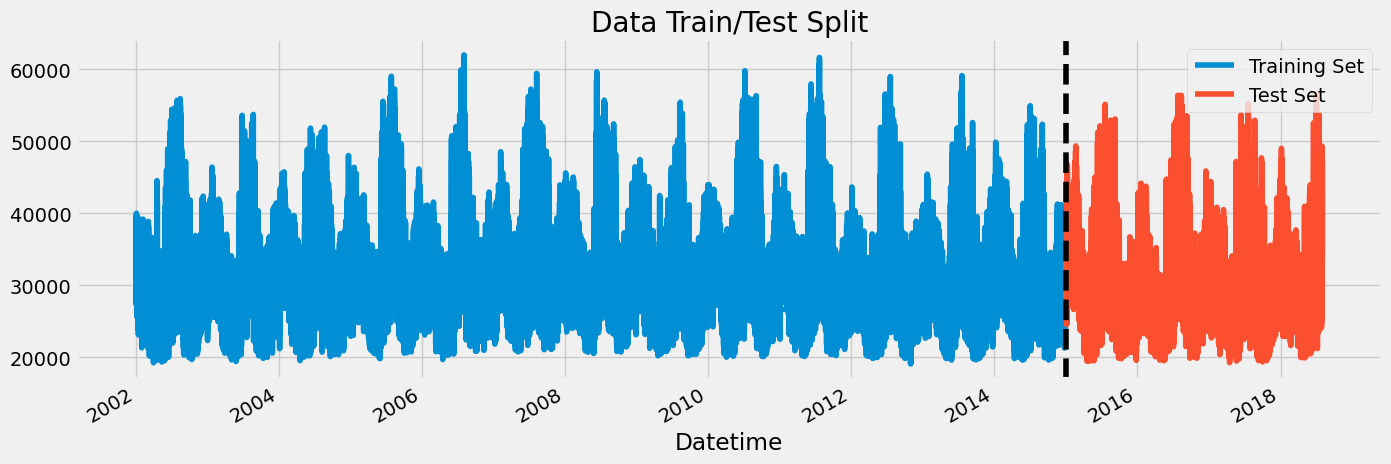

In [8]:
# Split the data into training and testing sets based on date
train = df.loc[df.index < '01-01-2015']    # Training data: all data before January 1, 2015
test = df.loc[df.index >= '01-01-2015']    # Test data: all data from January 1, 2015 onwards

# Create a visualization showing the train/test split
fig, ax = plt.subplots(figsize=(15, 5))    # Create figure and axis objects with specified size

# Plot training data
train.plot(
    ax=ax,                    # Plot on the created axis
    label='Training Set',     # Label for the legend
    title='Data Train/Test Split'  # Set the plot title
)

# Plot test data on the same axis
test.plot(
    ax=ax,                    # Plot on the same axis as training data
    label='Test Set'          # Label for the legend
)

# Add a vertical line to clearly mark the split point
ax.axvline(
    '01-01-2015',            # Date where the vertical line is drawn
    color='black',           # Line color
    ls='--'                  # Line style: dashed
)

# Add legend to distinguish between training and test sets
ax.legend(['Training Set', 'Test Set'])

# Display the plot
plt.show()

### Time Series Cross Validation

In [9]:
# Import TimeSeriesSplit for proper time series cross-validation
from sklearn.model_selection import TimeSeriesSplit

# Configure TimeSeriesSplit for time series cross-validation
tss = TimeSeriesSplit(
    n_splits=5,           # Create 5 different train/validation splits
    test_size=24*365*1,   # Test set size: 24 hours × 365 days × 1 year = 8,760 data points (1 year)
    gap=24                # Gap of 24 hours between training and test sets
                          # This prevents data leakage by ensuring no overlap between train/test
)

# Sort the DataFrame by index (datetime) to ensure chronological order
df = df.sort_index()      # Essential for time series analysis - data must be in temporal order

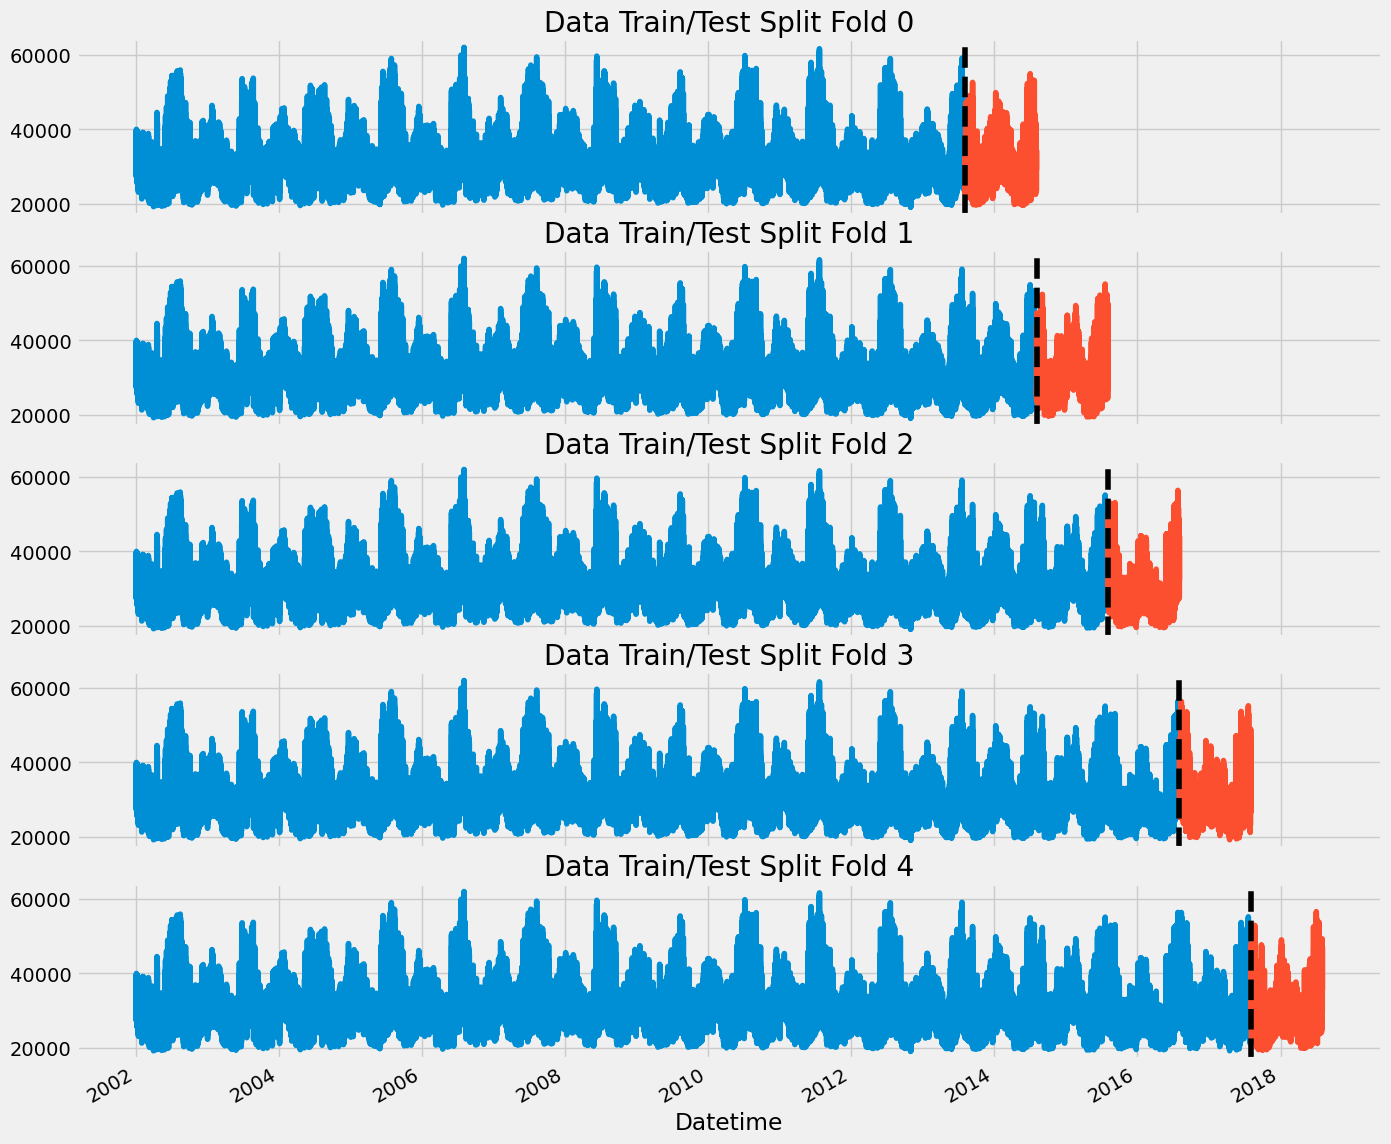

In [10]:
# Create a visualization showing all 5 time series cross-validation folds
fig, axs = plt.subplots(
    5, 1,                    # Create 5 subplots arranged vertically (5 rows, 1 column)
    figsize=(15, 15),        # Set figure size: 15 inches wide, 15 inches tall
    sharex=True              # Share x-axis across all subplots for easy comparison
)

fold = 0                     # Initialize fold counter

# Loop through each train/validation split generated by TimeSeriesSplit
for train_idx, val_idx in tss.split(df):
    # Extract training and validation data for current fold
    train = df.iloc[train_idx]    # Training data using integer-based indexing
    test = df.iloc[val_idx]       # Validation data using integer-based indexing
    
    # Plot training data for current fold
    train['PJME_MW'].plot(
        ax=axs[fold],                           # Plot on the current fold's subplot
        label='Training Set',                   # Label for legend
        title=f'Data Train/Test Split Fold {fold}'  # Title showing current fold number
    )
    
    # Plot validation data for current fold
    test['PJME_MW'].plot(
        ax=axs[fold],            # Plot on same subplot as training data
        label='Test Set'         # Label for legend
    )
    
    # Add vertical line to mark the start of validation period
    axs[fold].axvline(
        test.index.min(),        # Position line at the beginning of test period
        color='black',           # Line color
        ls='--'                  # Dashed line style
    )
    
    fold += 1                    # Move to next fold

# Display all subplots
plt.show()

### Forecasting Horizon Explained
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    Extracts various temporal components from datetime index for use as model features.
    """
    df = df.copy()  # Create a copy to avoid modifying the original DataFrame
    
    # Extract hour of day (0-23)
    # Useful for capturing daily energy usage patterns (peak hours vs off-peak)
    df['hour'] = df.index.hour
    
    # Extract day of week (0=Monday, 6=Sunday)  
    # Captures weekly patterns (weekday vs weekend energy usage)
    df['dayofweek'] = df.index.dayofweek
    
    # Extract quarter of year (1-4)
    # Captures seasonal patterns across quarters
    df['quarter'] = df.index.quarter
    
    # Extract month of year (1-12)
    # Captures monthly seasonal variations (heating/cooling seasons)
    df['month'] = df.index.month
    
    # Extract year
    # Captures long-term trends and year-over-year changes
    df['year'] = df.index.year
    
    # Extract day of year (1-365/366)
    # Captures annual seasonal patterns with finer granularity than month
    df['dayofyear'] = df.index.dayofyear
    
    # Extract day of month (1-31)
    # Captures monthly billing cycles or end-of-month patterns
    df['dayofmonth'] = df.index.day
    
    # Extract week of year (1-53)
    # Uses ISO calendar week numbering for consistent weekly patterns
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

# Apply feature engineering to the dataset
df = create_features(df)  # Add all temporal features to the DataFrame

### Lag Features

In [12]:
def add_lags(df):
    """
    Add lagged features based on previous years' values at the same time.
    Creates features that capture year-over-year patterns and trends.
    """
    # Create a dictionary mapping datetime index to target values for fast lookup
    target_map = df['PJME_MW'].to_dict()
    
    # Create lag1: same day/time from 1 year ago (364 days = ~1 year accounting for leap years)
    # This captures seasonal patterns - energy usage this time last year
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    
    # Create lag2: same day/time from 2 years ago (728 days = ~2 years)
    # Provides additional historical context and helps identify multi-year trends
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    
    # Create lag3: same day/time from 3 years ago (1092 days = ~3 years)
    # Captures longer-term patterns and provides more robust seasonal baselines
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    
    return df

# Note: These lag features will contain NaN values for early dates in the dataset
# where historical data isn't available (first 3 years won't have all lag features)

In [13]:
df = add_lags(df)

### Train Using Cross Validation

In [14]:
# Set up time series cross-validation with same parameters as before
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()  # Ensure data is in chronological order

# Initialize tracking variables for cross-validation results
fold = 0        # Counter for current fold number
preds = []      # List to store predictions from each fold
scores = []     # List to store RMSE scores from each fold

# Perform time series cross-validation
for train_idx, val_idx in tss.split(df):
    # Split data into training and validation sets for current fold
    train = df.iloc[train_idx]  # Training data using integer indices
    test = df.iloc[val_idx]     # Validation data using integer indices

    # Apply feature engineering to both training and validation sets
    train = create_features(train)  # Add temporal features to training data
    test = create_features(test)    # Add temporal features to validation data

    # Define which features to use for modeling
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']  # Mix of temporal and lag features
    TARGET = 'PJME_MW'  # Target variable (energy consumption)

    # Prepare feature matrices and target vectors
    X_train = train[FEATURES]  # Training features
    y_train = train[TARGET]    # Training target values

    X_test = test[FEATURES]    # Validation features  
    y_test = test[TARGET]      # Validation target values

    # Configure XGBoost regressor with specific hyperparameters
    reg = xgb.XGBRegressor(
        base_score=0.5,              # Initial prediction baseline
        booster='gbtree',            # Use gradient boosted trees
        n_estimators=1000,           # Maximum number of trees to build
        early_stopping_rounds=50,    # Stop training if no improvement for 50 rounds
        objective='reg:linear',      # Linear regression objective (deprecated, now 'reg:squarederror')
        max_depth=3,                 # Maximum tree depth (shallow trees to prevent overfitting)
        learning_rate=0.01           # Low learning rate for stable training
    )
    
    # Train the model with validation monitoring
    reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],  # Monitor both train and validation error
        verbose=10  # Print training progress every 100 iterations
    )

    # Make predictions on validation set
    y_pred = reg.predict(X_test)
    preds.append(y_pred)  # Store predictions for this fold

    # Calculate and store RMSE score for this fold
    score = np.sqrt(mean_squared_error(y_test, y_pred))  # Root Mean Squared Error
    scores.append(score)  # Add score to tracking list

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163
[10]	validation_0-rmse:29656.38509	validation_1-rmse:28899.26242
[20]	validation_0-rmse:26878.86342	validation_1-rmse:26135.03374
[30]	validation_0-rmse:24371.76538	validation_1-rmse:23643.79753
[40]	validation_0-rmse:22109.46535	validation_1-rmse:21400.08807


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [07:57:03] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[50]	validation_0-rmse:20068.71736	validation_1-rmse:19377.87675
[60]	validation_0-rmse:18228.24054	validation_1-rmse:17546.14606
[70]	validation_0-rmse:16570.49989	validation_1-rmse:15898.91143
[80]	validation_0-rmse:15078.78042	validation_1-rmse:14419.37499
[90]	validation_0-rmse:13737.52074	validation_1-rmse:13095.49124
[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[110]	validation_0-rmse:11452.30260	validation_1-rmse:10842.62265
[120]	validation_0-rmse:10484.84924	validation_1-rmse:9887.22008
[130]	validation_0-rmse:9620.31399	validation_1-rmse:9038.38078
[140]	validation_0-rmse:8849.83831	validation_1-rmse:8285.14208
[150]	validation_0-rmse:8163.61971	validation_1-rmse:7620.85115
[160]	validation_0-rmse:7555.30429	validation_1-rmse:7037.77634
[170]	validation_0-rmse:7015.81519	validation_1-rmse:6529.70092
[180]	validation_0-rmse:6540.21933	validation_1-rmse:6082.46394
[190]	validation_0-rmse:6122.32754	validation_1-rmse:5695.16861
[200]	validation_0-rmse:5747.9

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [07:57:06] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[40]	validation_0-rmse:22069.21391	validation_1-rmse:21651.52250
[50]	validation_0-rmse:20033.02956	validation_1-rmse:19640.28652
[60]	validation_0-rmse:18196.98562	validation_1-rmse:17827.30258
[70]	validation_0-rmse:16542.54635	validation_1-rmse:16188.53654
[80]	validation_0-rmse:15053.97206	validation_1-rmse:14723.51923
[90]	validation_0-rmse:13715.78165	validation_1-rmse:13405.71156
[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[110]	validation_0-rmse:11435.80447	validation_1-rmse:11164.53831
[120]	validation_0-rmse:10471.06176	validation_1-rmse:10219.45705
[130]	validation_0-rmse:9608.70566	validation_1-rmse:9372.40117
[140]	validation_0-rmse:8839.67030	validation_1-rmse:8624.40797
[150]	validation_0-rmse:8155.98921	validation_1-rmse:7964.14044
[160]	validation_0-rmse:7549.45151	validation_1-rmse:7380.04496
[170]	validation_0-rmse:7012.11818	validation_1-rmse:6868.38321
[180]	validation_0-rmse:6537.76443	validation_1-rmse:6412.23427
[190]	validation_0-rmse:6120

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [07:57:11] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[40]	validation_0-rmse:22041.00930	validation_1-rmse:20542.11943
[50]	validation_0-rmse:20007.31315	validation_1-rmse:18530.58160
[60]	validation_0-rmse:18173.46796	validation_1-rmse:16715.89109
[70]	validation_0-rmse:16521.76353	validation_1-rmse:15086.53115
[80]	validation_0-rmse:15035.41081	validation_1-rmse:13620.05404
[90]	validation_0-rmse:13699.15156	validation_1-rmse:12307.59866
[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[110]	validation_0-rmse:11423.35514	validation_1-rmse:10089.85597
[120]	validation_0-rmse:10460.23658	validation_1-rmse:9159.68749
[130]	validation_0-rmse:9598.36656	validation_1-rmse:8329.93934
[140]	validation_0-rmse:8830.28961	validation_1-rmse:7598.71951
[150]	validation_0-rmse:8146.55984	validation_1-rmse:6951.36406
[160]	validation_0-rmse:7540.19335	validation_1-rmse:6387.29422
[170]	validation_0-rmse:7003.64501	validation_1-rmse:5901.62634
[180]	validation_0-rmse:6530.77105	validation_1-rmse:5481.39453
[190]	validation_0-rmse:6115.

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [07:57:13] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[40]	validation_0-rmse:21973.13857	validation_1-rmse:21218.67185
[50]	validation_0-rmse:19945.72578	validation_1-rmse:19263.61918
[60]	validation_0-rmse:18117.96862	validation_1-rmse:17489.54545
[70]	validation_0-rmse:16471.70404	validation_1-rmse:15890.64606
[80]	validation_0-rmse:14990.25503	validation_1-rmse:14455.60522
[90]	validation_0-rmse:13658.40369	validation_1-rmse:13171.70875
[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[110]	validation_0-rmse:11389.81675	validation_1-rmse:10995.63040
[120]	validation_0-rmse:10429.64880	validation_1-rmse:10081.32257
[130]	validation_0-rmse:9571.53160	validation_1-rmse:9267.80450
[140]	validation_0-rmse:8806.28663	validation_1-rmse:8552.34996
[150]	validation_0-rmse:8125.73265	validation_1-rmse:7923.59465
[160]	validation_0-rmse:7521.25239	validation_1-rmse:7376.51431
[170]	validation_0-rmse:6987.62477	validation_1-rmse:6894.14177
[180]	validation_0-rmse:6515.41057	validation_1-rmse:6472.05256
[190]	validation_0-rmse:6100

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [07:57:18] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[40]	validation_0-rmse:21931.25341	validation_1-rmse:21167.13813
[50]	validation_0-rmse:19908.83990	validation_1-rmse:19201.48686
[60]	validation_0-rmse:18085.98117	validation_1-rmse:17432.43743
[70]	validation_0-rmse:16443.84195	validation_1-rmse:15839.77087
[80]	validation_0-rmse:14966.33522	validation_1-rmse:14407.14583
[90]	validation_0-rmse:13638.20190	validation_1-rmse:13118.82534
[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[110]	validation_0-rmse:11376.68613	validation_1-rmse:10929.61649
[120]	validation_0-rmse:10419.89463	validation_1-rmse:10008.60955
[130]	validation_0-rmse:9565.22138	validation_1-rmse:9182.24580
[140]	validation_0-rmse:8803.48690	validation_1-rmse:8449.05281
[150]	validation_0-rmse:8125.92521	validation_1-rmse:7804.06877
[160]	validation_0-rmse:7524.72249	validation_1-rmse:7239.04400
[170]	validation_0-rmse:6992.13959	validation_1-rmse:6744.04126
[180]	validation_0-rmse:6523.86003	validation_1-rmse:6311.33524
[190]	validation_0-rmse:6112

In [15]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3742.5833
Fold scores:[3760.8277187583353, 3420.313091887879, 3478.018038580526, 4052.5712055405547, 4001.186553933809]


### Predicting the Future
* Retraining on all data
* To Predict the future we need an emtpy dataframe for future date ranges.
* Run those dates through our feature creation code + lag creation


In [16]:
# Train final model on the complete dataset for production use
# After cross-validation confirmed the model works well, retrain on all available data

# Apply feature engineering to the full dataset
df = create_features(df)  # Add all temporal features to the complete dataset

# Use the same feature set that performed well in cross-validation
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']  # Temporal and lag features
TARGET = 'PJME_MW'  # Target variable (energy consumption)

# Prepare feature matrix and target vector using ALL available data
X_all = df[FEATURES]  # All features from the complete dataset
y_all = df[TARGET]    # All target values from the complete dataset

# Configure XGBoost with same hyperparameters but fewer estimators
reg = xgb.XGBRegressor(
    base_score=0.5,          # Initial prediction baseline
    booster='gbtree',        # Use gradient boosted trees
    n_estimators=500,        # Reduced from 1000 since we're not using early stopping
    objective='reg:linear',  # Linear regression objective
    max_depth=3,             # Shallow trees to prevent overfitting
    learning_rate=0.01       # Low learning rate for stable training
)

# Train the final model on all available data
reg.fit(
    X_all, y_all,
    eval_set=[(X_all, y_all)],  # Monitor training error (no separate validation set)
    verbose=100  # Print training progress every 100 iterations
)

# This final model can now be used for making predictions on new, unseen data

[0]	validation_0-rmse:32403.88991


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:59:39] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [17]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')   # Generate hourly timestamps from Aug 3, 2018 to Aug 1, 2019 (inclusive of start, exclusive of end)
future_df = pd.DataFrame(index=future)                         # Build an empty DataFrame indexed by those future timestamps
future_df['isFuture'] = True                                   # Mark all rows in the future window as "future"

df['isFuture'] = False                                         # Mark existing (historical) rows as not future
df_and_future = pd.concat([df, future_df])                     # Stack historical and future frames together by index (rows)

df_and_future = create_features(df_and_future)                 # Derive calendar/time/other features (assumes function is defined elsewhere)
df_and_future = add_lags(df_and_future)                        # Add lagged target/feature columns for modeling (assumes function is defined elsewhere)


In [18]:
future_w_features = df_and_future.query('isFuture').copy()  # Filter rows where isFuture==True using pandas.query, then .copy() to avoid SettingWithCopy warnings


### Predict the future

In [19]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])  # Run model inference on the selected feature columns and store the prediction in a new 'pred' column


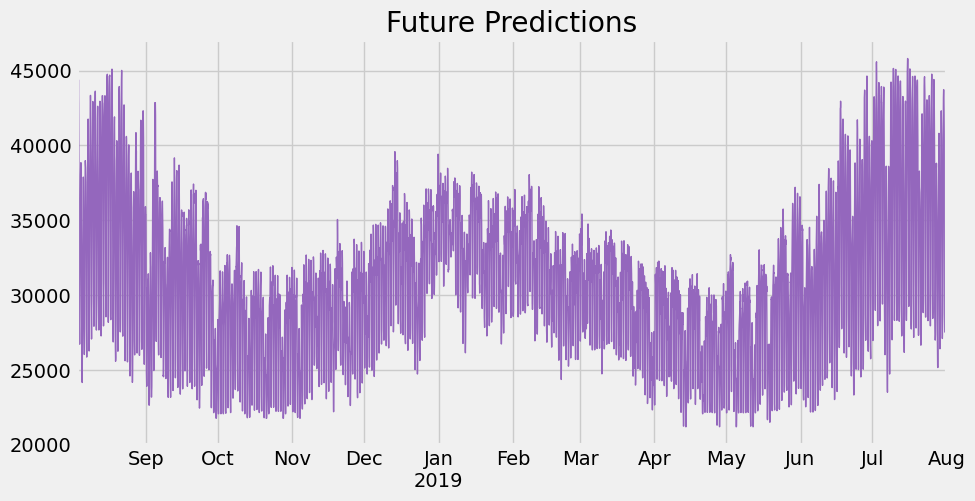

In [20]:
future_w_features['pred'].plot(                 # Plot the 'pred' series as a line chart
    figsize=(10, 5),                            # Figure size in inches: width=10, height=5
    color=color_pal[4],                         # Use the 5th color from a predefined palette
    ms=1,                                       # Marker size (only applies if a marker is set)
    lw=1,                                       # Line width (thin line)
    title='Future Predictions'                  # Chart title
)
plt.show()                                      # Render the figure
